# ADANNs for the Burgers PDE
Adjusted from Operator_learning_Burgers.ipynb from overview article

# Setup

We consider the periodic burgers equation in 1d:
$$
    \partial_t u (t, x)
=
    \nu (\partial_{x, x} u)(t, x) - \frac{(\partial_x u^2)(t, x)}{2}
=
    \nu (\partial_{x, x} u)(t, x) - (\partial_x u)(t, x) u(t, x),
$$
for $(t, x) \in [0,T] \times [0, S]$ with periodic boundary conditions.

We want to approximate the map
$$
\Phi(u(0, \cdot)) = u(T, \cdot).
$$

Problem parameters:  $T, S, \nu \in (0,\infty)$ and distribution of initial value

In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
import torch
import openpyxl
import os
import json
import seaborn as sns
sns.set_style("white")

sys.path.insert(1, '../1_Modules')

# Importing the modules
import random_function_generators
import ode_methods
import training
import training_samples_generators
import operator_learning_models
import utils
import burgers_classical_methods
import evaluation_utils
import documentation_utils
import PDE_operations


sys.path.insert(1, '1_ADANN_Modules')

import ADANNs
import ADANNs_training
import ADANNs_grid
import ADANNs_opt

In [2]:
# Reloading the modules
importlib.reload(random_function_generators)
importlib.reload(ode_methods)
importlib.reload(training)
importlib.reload(training_samples_generators)
importlib.reload(utils)
importlib.reload(operator_learning_models)
importlib.reload(burgers_classical_methods)
importlib.reload(evaluation_utils)
importlib.reload(documentation_utils)
importlib.reload(PDE_operations)
importlib.reload(ADANNs)
importlib.reload(ADANNs_training)
importlib.reload(ADANNs_grid)
importlib.reload(ADANNs_opt)

from random_function_generators import *
from ode_methods import *
from training import *
from training_samples_generators import *
from operator_learning_models import *
from utils import *
from burgers_classical_methods import *
from evaluation_utils import *
from documentation_utils import *
from PDE_operations import *
from ADANNs import *
from ADANNs_training import *
from ADANNs_grid import *
from ADANNs_opt import *

In [3]:
test_run = False

#Problem setup periodic Burgers PDE in 1d
###################################################
T = 1.
space_size = 2 * np.pi
laplace_factor = 0.1
dim = 1 # Dimension can only be 1 for Burgers

# initial value
var = 1000
decay_rate = 3.
offset = np.power(var, 1/decay_rate)
inner_decay = 2.
initial_value_generator = RandnFourierSeriesGenerator([var, decay_rate, offset, inner_decay, space_size, 1])

In [4]:
# Discretization operations
x_values = x_values_periodic
reduce_dimension = reduce_dimension_periodic
get_higher_nr_spacediscr = get_higher_nr_spacediscr_periodic
create_boundary_values = create_boundary_values_periodic

In [5]:
# Quantities derived from setup
###################################################
# Name of the PDE
pde_name = f"Burgers_T{T}_S{space_size}_nu{laplace_factor}_var{var}_decay{decay_rate}_offset{offset}_innerdecay{inner_decay}"

#Create folder for all outputs
# output_folder_dir = create_output_folder(pde_name)
output_folder_dir = "Z Outputs/ADANNs (Server) - Full experiments/Z Outputs/ZZ 2024-04-18 13h38m41s Burgers_T1.0_S6.283185307179586_nu0.1_var1000_decay3.0_offset9.999999999999998_innerdecay2.0/"

#Prepare df to store data
methods_data = pd.DataFrame(columns=["nr_params", "training_time", "test_time", "L2_error", "done_trainsteps", "learning_rate_history", "batch_size_history"])
methods = {}

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Create Train and Test sets

In [8]:
generate_data = True
data_load_folder = "2023-06-29 21h55m Code output/"

#Nr of input points allowed to be used by methods
nr_spacediscr = 32

#Method for reference solutions for training of models
reference_algorithm = lambda initial_values, nr_timesteps: burgers_spectral_freqsp_lirk(initial_values, T, laplace_factor, space_size, nr_timesteps)

# Train set parameters
train_space_resolution_step = 2 if test_run else 4
train_nr_timesteps = 20 if test_run else 1000
nr_train_samples = 2**12 if test_run else 2**18
nr_validation_samples = 2**10 if test_run else 2**14

# Test set parameters
test_space_resolution_step = 2 if test_run else 8
test_nr_timesteps = 50 if test_run else 1500
nr_test_samples = 2**10 if test_run else 2**14

only_save_rough = True

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

parameters = {
    'T': T,
    'space_size': space_size,
    'laplace_factor': laplace_factor,
    'var': var,
    'decay_rate': decay_rate,
    'offset': offset,
    'inner_decay': inner_decay,
    'nr_spacediscr': nr_spacediscr,
    'train_space_resolution_step': train_space_resolution_step,
    'train_nr_timesteps': train_nr_timesteps,
    'nr_train_samples': nr_train_samples,
    'nr_validation_samples': nr_validation_samples,
    'test_space_resolution_step': test_space_resolution_step,
    'nr_test_samples': nr_test_samples,
    'test_nr_timesteps': test_nr_timesteps,
    'reference_algorithm': reference_algorithm.__name__,
    'only_save_rough': only_save_rough
}

# save parametesr
with open(output_folder_dir + 'train_test_parameters.json', 'w') as fp:
    json.dump(parameters, fp)

In [ ]:
# Produce train and test data
train_nr_spacediscr = get_higher_nr_spacediscr(nr_spacediscr, train_space_resolution_step)
test_nr_spacediscr = get_higher_nr_spacediscr(nr_spacediscr, test_space_resolution_step)

print("Generating train samples")
train_initial_values_fine, train_ref_sol_fine, train_initial_values_rough, train_ref_sol_rough = (
    get_data(
        initial_value_generator, reference_algorithm, 
        nr_train_samples, train_nr_spacediscr, train_nr_timesteps, 
        reduce_dimension, train_space_resolution_step, 'train', 
        output_folder_dir, generate_data, data_load_folder, parameters, only_save_rough
    ))
training_samples_generator = TrainingSamplesGeneratorFromSolutions(train_initial_values_rough, train_ref_sol_rough)

print("Generating validation samples")
validation_initial_values_fine, validation_ref_sol_fine, validation_initial_values_rough, validation_ref_sol_rough = (
    get_data(
        initial_value_generator, reference_algorithm, 
        nr_validation_samples, test_nr_spacediscr, test_nr_timesteps, 
        reduce_dimension, test_space_resolution_step, 'validate', 
        output_folder_dir, generate_data, data_load_folder, parameters, only_save_rough
    ))

print("Generating test samples")
test_initial_values_fine, test_ref_sol_fine, test_initial_values_rough, test_ref_sol_rough = (
    get_data(
        initial_value_generator, reference_algorithm, 
        nr_test_samples, test_nr_spacediscr, test_nr_timesteps, 
        reduce_dimension, test_space_resolution_step, 'test', 
        output_folder_dir, generate_data, data_load_folder, parameters, only_save_rough
    ))

In [ ]:
#Plot some reference solutions 
plot_reference_solutions(train_initial_values_rough, train_ref_sol_rough, 4, dim, x_values, space_size, pde_name, output_folder_dir)

# Create models and methods to be tested

In [ ]:
# Optimizer
optimizer_class = torch.optim.Adam
# Loss function
loss_fn = torch.nn.MSELoss()

## Create and train ADANNs

In [10]:
# Training hyperparams

################
# BASE
base_training_kwargs = {
    "max_trainsteps": 1 if test_run else 100000,
    "initial_batchsize": 2**8 if test_run else 2**10,
    "max_batchsize": 2**8 if test_run else 2**10,
    "output_steps": 400 if test_run else 400,
    "eval_steps": 400 if test_run else 400,
    "improvement_tolerance": 0.96 if test_run else 0.96,
    "initial_lr": None if test_run else None
}

# Learning rate parameters
local_learning_rates = False if test_run else True
base_lr_test_trainsteps = 1 if test_run else 50
base_smallest_power = -10.
base_largest_power = 2.
base_maxiter = 1 if test_run else 15
base_lr_search_parameters = [base_lr_test_trainsteps, base_smallest_power, base_largest_power, base_maxiter]


################
# DIFF
only_train_base = False

diff_training_kwargs = {
    "max_trainsteps": 1 if test_run else 100000,
    "initial_batchsize": base_training_kwargs["initial_batchsize"],
    "max_batchsize": base_training_kwargs["max_batchsize"],
    "output_steps": base_training_kwargs["output_steps"],
    "eval_steps": base_training_kwargs["eval_steps"],
    "improvement_tolerance": base_training_kwargs["improvement_tolerance"],
    "initial_lr": None if test_run else None
}

# Learning rate parameters
diff_lr_test_trainsteps = 1 if test_run else 50
diff_smallest_power = -10
diff_largest_power = 0.
diff_maxiter = 1 if test_run else 15
diff_lr_search_parameters = [diff_lr_test_trainsteps, diff_smallest_power, diff_largest_power, diff_maxiter]

# ADANNs Settings
ADANN_base_model_class = SecondOrderLirkFDMPeriodicBurgersAdannBasemodel_learnFirstOrder
base_model_kwargs = {
    "T": T, 
    "laplace_factor": laplace_factor, 
    "space_size": space_size, 
    "nr_spacediscr": nr_spacediscr
}

# diff_model_class = FNOnDModel
# diff_model_params = [16, 20, 4, 1]
diff_model_class = ANNModel
diff_model_params = [[nr_spacediscr, 2**8, 2**10, 2**8, nr_spacediscr]]

#### ADANN Experiment 1: Grid based approach

In [ ]:
#Grid
grid_p1_low = 0.3 if test_run else 0.1
grid_p1_high = 1.
grid_nr_p1_steps = 1 if test_run else 4

grid_p2_low = 0.3 if test_run else 0.1
grid_p2_high = 1.
grid_nr_p2_steps = 1 if test_run else 4

param_grid_parameters = [grid_p1_low, grid_p1_high, grid_nr_p1_steps, grid_p2_low, grid_p2_high, grid_nr_p2_steps]

list_base_nr_timesteps_grid = [4, 8, 16] if test_run else [4, 8, 16]

In [ ]:
adann_grid(
    ADANN_base_model_class=ADANN_base_model_class,
    base_model_kwargs=base_model_kwargs,
    diff_model_class=diff_model_class,
    diff_model_params=diff_model_params,
    list_base_nr_timesteps=list_base_nr_timesteps_grid,
    param_grid_parameters=param_grid_parameters,
    training_samples_generator=training_samples_generator,
    optimizer_class=optimizer_class,
    loss_fn=loss_fn,
    base_training_kwargs=base_training_kwargs,
    base_lr_search_parameters=base_lr_search_parameters,
    diff_training_kwargs=diff_training_kwargs,
    diff_lr_search_parameters=diff_lr_search_parameters,
    output_folder_dir=output_folder_dir,
    methods=methods,
    methods_data=methods_data,
    test_input_values_rough=test_initial_values_rough,
    test_ref_sol_rough=test_ref_sol_rough,
    validation_input_values_rough=validation_initial_values_rough,
    validation_ref_sol_rough=validation_ref_sol_rough,
    pde_name=pde_name,
    space_size=space_size,
    dim=dim,
    only_train_base=only_train_base,
    local_learning_rates=local_learning_rates
)

In [ ]:
plot_error_heat_maps_combined(output_folder_dir, only_train_base, list_base_nr_timesteps_grid, pde_name=pde_name)

#### ADANN Experiment 2: Optimization based approach


In [ ]:
# p1_low = 0.1 if test_run else grid_p1_low
# p1_high = 0.9 if test_run else grid_p1_high
# p2_low = 0.2 if test_run else grid_p2_low
# p2_high = 0.9 if test_run else grid_p2_high
# n_calls = 25 if test_run else 25
# 
# p1_low_start = p1_low
# p1_high_start = p1_high
# p2_low_start = p2_low
# p2_high_start = p2_high
# n_random_starts = 16 if test_run else 16
# 
# opt_params = [p1_low, p1_high, p2_low, p2_high, n_calls, p1_low_start, p1_high_start, p2_low_start, p2_high_start, n_random_starts]
# 
# list_base_nr_timesteps_opt = [4, 8, 16] if test_run else [4, 8, 16]

In [ ]:
# adann_opt(
#     ADANN_base_model_class=ADANN_base_model_class,
#     base_model_kwargs=base_model_kwargs,
#     diff_model_class=diff_model_class,
#     diff_model_params=diff_model_params,
#     list_base_nr_timesteps=list_base_nr_timesteps_opt,
#     opt_params=opt_params,
#     training_samples_generator=training_samples_generator,
#     optimizer_class=optimizer_class,
#     loss_fn=loss_fn,
#     base_training_kwargs=base_training_kwargs,
#     base_lr_search_parameters=base_lr_search_parameters,
#     diff_training_kwargs=diff_training_kwargs,
#     diff_lr_search_parameters=diff_lr_search_parameters,
#     output_folder_dir=output_folder_dir,
#     methods=methods,
#     methods_data=methods_data,
#     test_input_values_rough=test_initial_values_rough,
#     test_ref_sol_rough=test_ref_sol_rough,
#     validation_input_values_rough=validation_initial_values_rough,
#     validation_ref_sol_rough=validation_ref_sol_rough,
#     pde_name=pde_name,
#     space_size=space_size,
#     dim=dim,
#     only_train_base=only_train_base,
#     local_learning_rates=local_learning_rates
# )

In [ ]:
# plot_opt_results_combined(output_folder_dir, pde_name=pde_name, list_base_nr_timesteps=list_base_nr_timesteps_opt, only_train_base=only_train_base, n_random_starts=opt_params[-1])

### Standard operator learning models

In [ ]:
# Training hyperparams
OL_training_kwargs = {
    "max_trainsteps": 1 if test_run else 100000,
    "initial_batchsize": base_training_kwargs["initial_batchsize"],
    "max_batchsize": base_training_kwargs["initial_batchsize"],
    "output_steps": 20 if test_run else 200,
    "eval_steps": 10 if test_run else diff_training_kwargs["eval_steps"],
    "improvement_tolerance": 0.8 if test_run else diff_training_kwargs["improvement_tolerance"],
    "initial_lr": None if test_run else None
}
nr_runs = 1 if test_run else grid_nr_p1_steps * grid_nr_p2_steps

# learning rates
local_learning_rates=False
lr_test_trainsteps = 20 if test_run else 100
smallest_power = -10
largest_power = 0.
maxiter = 1 if test_run else 15
OL_lr_search_parameters = [lr_test_trainsteps, smallest_power, largest_power, maxiter]

In [ ]:
#ANN models
ann_foldername = output_folder_dir + "Results_ANN"

#ANN Parameters [layer_dims]
list_ann_params = [
    [[nr_spacediscr, 2**7, 2**9, 2**7, nr_spacediscr]],
    [[nr_spacediscr, 2**8, 2**10, 2**8, nr_spacediscr]],
    [[nr_spacediscr, 2**8, 2**10, 2**12, 2**10, 2**8, nr_spacediscr]]
]

create_and_train_models(
    modelclass = ANNModel, 
    list_params = list_ann_params,
    training_samples_generator = training_samples_generator,
    optimizer_class = optimizer_class,
    loss_fn = loss_fn,
    training_kwargs=OL_training_kwargs,
    lr_search_params=OL_lr_search_parameters,
    nr_runs = nr_runs,
    methods = methods,
    methods_data = methods_data,
    foldername = ann_foldername,
    test_input_values = test_initial_values_rough,
    test_ref_sol = test_ref_sol_rough,
    validation_input_values = validation_initial_values_rough,
    validation_ref_sol = validation_ref_sol_rough,
    pde_name = pde_name,
    local_learning_rates=local_learning_rates
)

In [ ]:
# FNO models
fno_foldername = output_folder_dir + "Results_FNO"

#list is [#modes, width, depth, dim]
list_fno_params = [
    [8, 20, 3, 1],
    [16, 30, 4, 1],
    [32, 40, 5, 1]
]

create_and_train_models(
    modelclass = FNOnDModel, 
    list_params = list_fno_params,
    training_samples_generator = training_samples_generator,
    optimizer_class = optimizer_class,
    loss_fn = loss_fn,
    training_kwargs=OL_training_kwargs,
    lr_search_params=OL_lr_search_parameters,
    nr_runs = nr_runs,
    methods = methods,
    methods_data = methods_data,
    foldername = fno_foldername,
    test_input_values = test_initial_values_rough,
    test_ref_sol = test_ref_sol_rough,
    validation_input_values = validation_initial_values_rough,
    validation_ref_sol = validation_ref_sol_rough,
    pde_name = pde_name,
    local_learning_rates=local_learning_rates
)

### Classical Methods

In [ ]:
# Discretization parameters
nr_timesteps_fdm = list_base_nr_timesteps_grid

#Create all methods for the correponding timesteps
# FDM (I do not evaluate the euler method at the moment)
for nr_timesteps in nr_timesteps_fdm:
    for v in [2]: 
        name = f"FDM ({nr_timesteps} Crank-Nicolson time steps)"
        methods[name] = SecondOrderLirkFDMPeriodicBurgersAdannBasemodel_learnFirstOrder(T, laplace_factor, space_size, nr_spacediscr, nr_timesteps, v).to(device)
        methods_data.at[name, "training_time"] = 0

In [ ]:
# for nr_timesteps in nr_timesteps_fdm:
#     for implicit_first in [False, True]:
#         name = f"Lax-Wendroff FDM ({nr_timesteps} Strang splitting steps with {implicit_first})"
#         methods[name] = lambda initial_values, nr_timesteps=nr_timesteps: burger_fdm_strang_splitting_lax_wendroff(initial_values, T, laplace_factor, space_size, nr_timesteps, implicit_first)
#         methods_data.at[name, "training_time"] = 0

# Evaluation

In [ ]:
# Evaluate all the methods and create plots
nr_of_eval_runs = 1 if test_run else 1000
plot_histogram = False if test_run else True

method_categories = (["ANN", "FNO", "FDM"] + 
                     (["ADANN base - grid"] if only_train_base else ["ADANN base - grid", "ADANN full - grid"]) +
                     (["ADANN base - EE"] if only_train_base else ["ADANN full - EE"])
                     )
space_grid = x_values(nr_spacediscr, space_size)

evaluate_and_plot(methods, 
                  methods_data, 
                  method_categories, 
                  test_initial_values_rough, 
                  test_ref_sol_rough, 
                  space_grid, 
                  space_size, 
                  output_folder_dir, 
                  pde_name, 
                  dim=dim, 
                  nr_of_eval_runs=nr_of_eval_runs, 
                  plot_histogram=plot_histogram,
                  legend_loc=None,
                  nr_of_plots=1 if test_run else 3
                  )

#Save all the data in an Excel sheet
local_vars = locals()
params_dict = {k: [v] for k, v in local_vars.items() if isinstance(v, (int, str, float)) and k[0] != '_'}
save_excel_sheet(methods_data, params_dict, output_folder_dir + f"Results_{pde_name}.xlsx")

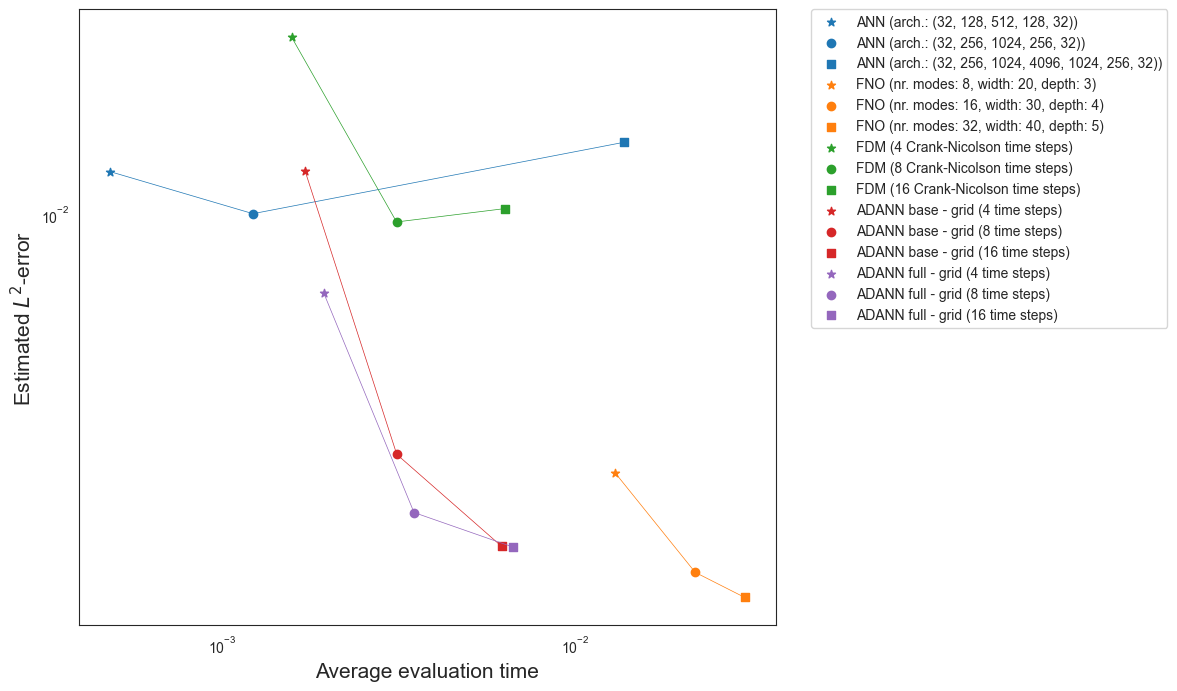

In [11]:
create_error_vs_comptime_plot(method_categories, output_folder_dir, pde_name)